In [2]:
import os
import numpy as np
import tensorflow as tf
import h5py
import math
from keras import layers
from keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D
from keras.models import Model, load_model
from keras.preprocessing import image
from keras.utils import layer_utils
from keras.utils.data_utils import get_file
from keras.applications.imagenet_utils import preprocess_input
import pydot
from keras.utils.vis_utils import model_to_dot
from keras.utils import plot_model
from keras.initializers import glorot_uniform
import scipy.misc
from matplotlib.pyplot import imshow
import matplotlib.pyplot as plt
%matplotlib inline
from ._conv import register_converters as _register_converters

import keras.backend as K
K.set_image_data_format('channels_last')
K.set_learning_phase(1)

In [3]:
#Build a Residual Network
#The identity block: skip connection "skips over" 3 layers.
def identity_block(X, f, filters, stage, block):
    """
    Implementation of the identity block: skip connection "skips over" 3 layers
    
    Arguments:
    X -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    f -- integer, specifying the shape of the middle CONV's window for the main path
    filters -- python list of integers, defining the number of filters in the CONV layers of the main path
    stage -- integer, used to name the layers, depending on their position in the network
    block -- string/character, used to name the layers, depending on their position in the network
    
    Returns:
    X -- output of the identity block, tensor of shape (n_H, n_W, n_C)
    """
    
    # defining name basis
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    
    # Retrieve Filters
    F1, F2, F3 = filters
    
    # Save the input value. You'll need this later to add back to the main path. 
    X_shortcut = X
    
    # First component of main path
    X = Conv2D(filters = F1, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + '2a', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2a')(X)
    X = Activation('relu')(X)
    
    # Second component of main path (≈3 lines)
    X = Conv2D(filters = F2, kernel_size = (f, f), strides = (1,1), padding = 'same', name = conv_name_base + '2b', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2b')(X)
    X = Activation('relu')(X)

    # Third component of main path (≈2 lines)
    X = Conv2D(filters = F3, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + '2c', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2c')(X)

    # Final step: Add shortcut value to main path, and pass it through a RELU activation (≈2 lines)
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)
    
    return X

In [4]:
#The convolutional block: CONV2D layer in the shortcut path
def convolutional_block(X, f, filters, stage, block, s = 2):
    """
    Implementation of the convolutional block: identity block with a CONV2D layer in the shortcut path
    
    Arguments:
    X -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    f -- integer, specifying the shape of the middle CONV's window for the main path
    filters -- python list of integers, defining the number of filters in the CONV layers of the main path
    stage -- integer, used to name the layers, depending on their position in the network
    block -- string/character, used to name the layers, depending on their position in the network
    s -- Integer, specifying the stride to be used
    
    Returns:
    X -- output of the convolutional block, tensor of shape (n_H, n_W, n_C)
    """
    
    # defining name basis
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    
    # Retrieve Filters
    F1, F2, F3 = filters
    
    # Save the input value
    X_shortcut = X
    
    ##### MAIN PATH #####
    # First component of main path 
    X = Conv2D(F1, (1, 1), strides = (s,s), padding = 'valid', name = conv_name_base + '2a', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2a')(X)
    X = Activation('relu')(X)
    
    # Second component of main path 
    X = Conv2D(F2, (f, f), strides = (1,1), padding = 'same', name = conv_name_base + '2b', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2b')(X)
    X = Activation('relu')(X)

    # Third component of main path 
    X = Conv2D(F3, (1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + '2c', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2c')(X)

    ##### SHORTCUT PATH #### 
    X_shortcut = Conv2D(F3, (1, 1), strides = (s, s), padding = 'valid', name = conv_name_base + 'l', kernel_initializer = glorot_uniform(seed=0))(X_shortcut)
    X_shortcut = BatchNormalization(axis = 3, name = bn_name_base + 'l')(X_shortcut)

    # Final step: Add shortcut value to main path, and pass it through a RELU activation 
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)
    
    return X    

In [5]:
#Build the ResNet model
def ResNet50(input_shape = (64, 64, 3), classes = 6):
    """
    Implementation of the popular ResNet50 the following architecture:
    CONV2D -> BATCHNORM -> RELU -> MAXPOOL -> CONVBLOCK -> IDBLOCK*2 -> CONVBLOCK -> IDBLOCK*3
    -> CONVBLOCK -> IDBLOCK*5 -> CONVBLOCK -> IDBLOCK*2 -> AVGPOOL -> TOPLAYER

    Arguments:
    input_shape -- shape of the images of the dataset
    classes -- integer, number of classes

    Returns:
    model -- a Model() instance in Keras
    """
    
    # Define the input as a tensor with shape input_shape
    X_input = Input(input_shape)

    
    # Zero-Padding
    X = ZeroPadding2D((3, 3))(X_input)
    
    # Stage 1:  CONV2D -> BATCHNORM -> RELU -> MAXPOOL 
    X = Conv2D(64, (7, 7), strides = (2, 2), name = 'conv1', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = 'bn_conv1')(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((3, 3), strides=(2, 2))(X)

    # Stage 2: CONVBLOCK -> IDBLOCK*2
    X = convolutional_block(X, f = 3, filters = [64, 64, 256], stage = 2, block='a', s = 1)
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='b')
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='c')

    # Stage 3: CONVBLOCK -> IDBLOCK*3
    X = convolutional_block(X, f = 3, filters = [128, 128, 512], stage = 3, block='a', s = 2)
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='b')
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='c')
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='d')

    # Stage 4: CONVBLOCK -> IDBLOCK*5
    X = convolutional_block(X, f = 3, filters = [256, 256, 1024], stage = 4, block='a', s = 2)
    X = identity_block(X, 3, [256, 256, 1024], stage = 4, block='b')
    X = identity_block(X, 3, [256, 256, 1024], stage = 4, block='c')
    X = identity_block(X, 3, [256, 256, 1024], stage = 4, block='d')
    X = identity_block(X, 3, [256, 256, 1024], stage = 4, block='e')
    X = identity_block(X, 3, [256, 256, 1024], stage = 4, block='f')

    # Stage 5: CONVBLOCK -> IDBLOCK*2 
    X = convolutional_block(X, f = 3, filters = [512, 512, 2048], stage = 5, block='a', s = 2)
    X = identity_block(X, 3, [512, 512, 2048], stage = 5, block='b')
    X = identity_block(X, 3, [512, 512, 2048], stage = 5, block='c')

    # AVGPOOL 
    X = AveragePooling2D((2, 2), name = 'avg_pool')(X)

    # output layer
    X = Flatten()(X)
    X = Dense(classes, activation='softmax', name='fc' + str(classes), kernel_initializer = glorot_uniform(seed=0))(X)
    
    
    # Create model
    model = Model(inputs = X_input, outputs = X, name='ResNet50')

    return model

In [7]:
res = ResNet50(input_shape = (64, 64, 3), classes = 6)

In [8]:
res.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [9]:
# load the SIGNS datasets
train_dataset = h5py.File('/Users/lixihan/Downloads/train_signs.h5', "r")
# training set features
X_train_orig = np.array(train_dataset["train_set_x"][:]) 
# training set labels
Y_train_orig = np.array(train_dataset["train_set_y"][:]) 

test_dataset = h5py.File('/Users/lixihan/Downloads/test_signs.h5', "r")
# test set features
X_test_orig = np.array(test_dataset["test_set_x"][:]) 
# test set labels
Y_test_orig = np.array(test_dataset["test_set_y"][:]) 

#list of classes
classes = np.array(test_dataset["list_classes"][:]) 
    
Y_train_orig = Y_train_orig.reshape((1, Y_train_orig.shape[0]))
Y_test_orig = Y_test_orig.reshape((1, Y_test_orig.shape[0]))

y = 3


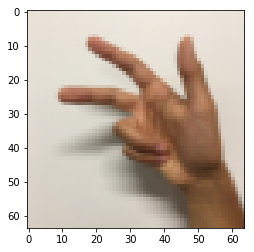

In [10]:
# Example of a picture
index = 100
plt.imshow(X_train_orig[index])
print ("y = " + str(np.squeeze(Y_train_orig[:, index])))

In [11]:
# Normalize image vectors
X_train = X_train_orig/255.
X_test = X_test_orig/255.

In [12]:
Y_train = np.eye(6)[Y_train_orig.reshape(-1)]
Y_test = np.eye(6)[Y_test_orig.reshape(-1)]

In [13]:
print ("number of training examples = " + str(X_train.shape[0]))
print ("number of test examples = " + str(X_test.shape[0]))
print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(Y_train.shape))
print ("X_test shape: " + str(X_test.shape))
print ("Y_test shape: " + str(Y_test.shape))

number of training examples = 1080
number of test examples = 120
X_train shape: (1080, 64, 64, 3)
Y_train shape: (1080, 6)
X_test shape: (120, 64, 64, 3)
Y_test shape: (120, 6)


In [14]:
# Fit the model with the training set
res.fit(X_train, Y_train, epochs = 10, batch_size = 32)

Epoch 1/10
1080/1080 [==============================] - 2360s 2s/step - loss: 3.0481 - acc: 0.1991
Epoch 2/10
1080/1080 [==============================] - 2221s 2s/step - loss: 2.3434 - acc: 0.2546
Epoch 3/10
1080/1080 [==============================] - 2219s 2s/step - loss: 2.1608 - acc: 0.3472
Epoch 4/10
1080/1080 [==============================] - 2214s 2s/step - loss: 1.8525 - acc: 0.4509
Epoch 5/10
1080/1080 [==============================] - 2230s 2s/step - loss: 1.5378 - acc: 0.5454
Epoch 6/10
1080/1080 [==============================] - 2233s 2s/step - loss: 1.3518 - acc: 0.6389
Epoch 7/10
1080/1080 [==============================] - 2246s 2s/step - loss: 1.2791 - acc: 0.6759
Epoch 8/10
1080/1080 [==============================] - 2237s 2s/step - loss: 1.3196 - acc: 0.7019
Epoch 9/10
1080/1080 [==============================] - 2244s 2s/step - loss: 1.0316 - acc: 0.7694
Epoch 10/10
1080/1080 [==============================] - 2234s 2s/step - loss: 0.4916 - acc: 0.8528


In [16]:
#Prediction
preds = res.evaluate(X_test, Y_test)
print ("Loss = " + str(preds[0]))
print ("Test Accuracy = " + str(preds[1]))

120/120 [==============================] - 92s 768ms/step
Loss = 1.1441852688789367
Test Accuracy = 0.7583333293596903


In [ ]:
res.summary()
res.save('/Users/lixihan/res.h5')

In [17]:
#REST API 
from PIL import Image
from flask import Flask, request, jsonify

In [18]:
app = Flask(__name__)
model = None

In [19]:
#load model
def load_model():
    global model
    model = res
    global graph
    graph = tf.get_default_graph()

In [20]:
#image preprocessing
def prepare_image(image, target):
    # if the image mode is not RGB, convert it
    if image.mode != "RGB":
        image = image.convert("RGB")

    # resize the input image and preprocess it
    image = image.resize(target)
    image = keras.preprocessing.image.img_to_array(image)
    image = np.expand_dims(image, 0)
    image = keras.applications.resnet50.preprocess_input(image)

    # return the processed image
    return image

In [21]:
@app.route("/predict", methods=["POST"])
def predict():
    # initialize the data dictionary that will be returned from the
    # view
    data = {"success": False}

    # ensure an image was properly uploaded to our endpoint
    if flask.request.method == "POST":
        if flask.request.files.get("image"):
            # read the image in PIL format
            image = request.files["image"].read()
            image = Image.open(io.BytesIO(image))

            # preprocess the image and prepare it for classification
            image = prepare_image(image, target=(64, 64))
            
            # classify the input image and then initialize the list
            # of predictions to return to the client
            with graph.as_default():
                preds = model.predict(image)
                results = keras.applications.resnet50.decode_predictions(preds)
            data["predictions"] = []

            # loop over the results and add them to the list of
            # returned predictions
            for (imagenetID, label, prob) in results[0]:
                r = {"label": label, "probability": float(prob)}
                data["predictions"].append(r)

            # indicate that the request was a success
            data["success"] = True

    # return the data dictionary as a JSON response
    return jsonify(data)


In [ ]:
if __name__ == "__main__":
    print(("* Loading Keras model and Flask starting server..."
        "please wait until server has fully started"))
    load_model()
    app.run()